In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 5000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [10,10,8,5,5,5]
cov = np.identity(6)
x_outliers =  pd.DataFrame(np.random.multivariate_normal(mean, cov, 200), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
features = ['f'+str(i) for i in range(1,7)]

In [9]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [10]:
X['pred_AD_score'] = if_model.decision_function(X[features])
X['pred_AD_score'] = -1*X['pred_AD_score']
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5195,8.581007,11.325021,8.603488,7.344705,4.950949,3.807997,1,0.167171
5196,9.981472,11.081814,7.801210,4.009249,2.802187,5.409102,1,0.161660
5197,8.833205,11.158474,8.508673,6.387289,5.736398,6.315690,1,0.137365
5198,9.522445,10.554313,6.977947,4.850168,5.638635,5.479775,1,0.087331
5199,10.561760,10.123583,9.276820,4.617383,4.616045,3.692287,1,0.146954


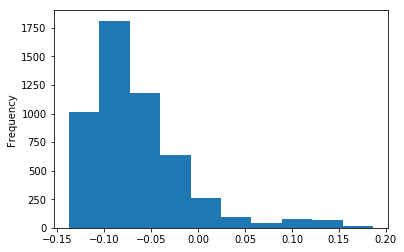

In [11]:
X['pred_AD_score'].plot(kind='hist')

In [12]:
bottom_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
top_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [13]:
top_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
bottom_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [14]:
top_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5018,11.604725,10.813264,6.989407,7.981032,6.691019,5.739783,1,0.186417
5077,10.388068,11.404389,8.374441,6.028412,2.746872,6.258572,1,0.182369
5094,11.168902,10.768438,8.050634,3.351375,3.832309,4.354036,1,0.179446
5049,11.414021,11.353221,8.920185,6.027261,3.726712,4.992048,1,0.177575
5107,9.035398,11.796575,9.388932,5.910233,7.439927,3.844411,1,0.176930
5131,10.774027,10.372848,10.157608,3.652165,4.615560,6.338348,1,0.169784
5175,9.771943,11.259052,7.124210,4.124759,8.138738,5.381751,1,0.168076
5195,8.581007,11.325021,8.603488,7.344705,4.950949,3.807997,1,0.167171
5154,11.416247,9.518175,8.530181,5.243588,2.519665,4.141324,1,0.162912
5196,9.981472,11.081814,7.801210,4.009249,2.802187,5.409102,1,0.161660


In [15]:
k = 20
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return -1*df

acme_ifo = ACME(model = if_model, target = 'AD_score', K=k, task='ad', score_function=score_function, features=features)
acme_ifo = acme_ifo.fit(X[features], robust = True)

In [16]:
#acme_local = acme_ifo.fit_local(X[features], top_anomalies.index[-1])
acme_local = acme_ifo.fit_local(X[features], bottom_anomalies.index[-1])
#acme_local = acme_ifo.fit_local(X[features], top_normal.index[-1])
#acme_local = acme_ifo.fit_local(X[features], bottom_normal.index[-1])

In [17]:
acme_local.summary_table(local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile
feature,,,,,,,
f1,0.082983,0.082983,0.010104,1.309068,0.000000,numeric,0.430385
f1,0.032096,0.032096,0.010104,3.459053,0.055556,numeric,0.430385
f1,0.030989,0.030989,0.010104,3.834435,0.111111,numeric,0.430385
f1,0.023771,0.023771,0.010104,4.068698,0.166667,numeric,0.430385
f1,0.023048,0.023048,0.010104,4.266739,0.222222,numeric,0.430385
...,...,...,...,...,...,...,...
f6,-0.035973,-0.035973,0.010104,5.925081,0.833333,numeric,0.978654
f6,-0.032004,-0.032004,0.010104,6.168589,0.888889,numeric,0.978654
f6,-0.010077,-0.010077,0.010104,6.525128,0.944444,numeric,0.978654


In [18]:
acme_local.feature_importance()

,importance
feature,
f1,0.024907
f2,0.023315
f3,0.022313
f6,0.022307
f5,0.018633
f4,0.015691


In [19]:
acme_local.feature_importance(local=True, weights = {'ratio':0.1,'delta':0.1,'change':0.3,'distance':0.5})

,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f6,0.729243,0.089409,1.0,0.034209,0.034312,-0.055097,0.010104,0.864760
f5,0.476300,0.083359,1.0,0.036517,0.053758,-0.029600,0.010104,0.837707
f3,0.235971,0.090689,1.0,0.111453,0.079392,-0.011296,0.010104,0.776939
f2,0.199151,0.104629,1.0,0.169124,0.093896,-0.010734,0.010104,0.745816
f1,0.049578,0.135990,0.0,1.000000,0.139351,0.003361,0.010104,0.018557
f4,0.000000,0.097698,0.0,1.000000,0.107802,0.010104,0.010104,0.009770


In [20]:
acme_local.feature_importance(local=True, weights = {'ratio':0.4,'delta':0.1,'change':0.3,'distance':0.2})

,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f6,0.729243,0.089409,1.0,0.034209,0.034312,-0.055097,0.010104,0.793796
f5,0.476300,0.083359,1.0,0.036517,0.053758,-0.029600,0.010104,0.691552
f3,0.235971,0.090689,1.0,0.111453,0.079392,-0.011296,0.010104,0.581167
f2,0.199151,0.104629,1.0,0.169124,0.093896,-0.010734,0.010104,0.556299
f1,0.049578,0.135990,0.0,1.000000,0.139351,0.003361,0.010104,0.033430
f4,0.000000,0.097698,0.0,1.000000,0.107802,0.010104,0.010104,0.009770


In [21]:
acme_local.feature_exploration('f1',local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile,size,direction
feature,,,,,,,,,
f1,0.072880,0.082983,0.010104,1.309068,0.000000,numeric,0.430385,0.1,anomalies
f1,0.021993,0.032096,0.010104,3.459053,0.055556,numeric,0.430385,0.1,anomalies
f1,0.020886,0.030989,0.010104,3.834435,0.111111,numeric,0.430385,0.1,anomalies
f1,0.013668,0.023771,0.010104,4.068698,0.166667,numeric,0.430385,0.1,anomalies
f1,0.012944,0.023048,0.010104,4.266739,0.222222,numeric,0.430385,0.1,anomalies
f1,0.013122,0.023225,0.010104,4.444865,0.277778,numeric,0.430385,0.1,anomalies
f1,0.013080,0.023183,0.010104,4.603118,0.333333,numeric,0.430385,0.1,anomalies
f1,0.002316,0.012419,0.010104,4.750633,0.388889,numeric,0.430385,0.1,anomalies
f1,0.000000,0.010104,0.010104,4.859097,0.430385,numeric,0.430385,0.5,anomalies


In [22]:
acme_local.feature_exploration('f2',local=True,plot=True)

In [23]:
acme_local.baseline_values()

,f1,f2,f3,f4,f5,f6
0,5.203106,5.174453,5.125215,4.996112,5.012707,4.980571


In [24]:
acme_local.summary_plot(local=True)

In [25]:
acme_local.summary_table(local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile
feature,,,,,,,
f1,0.082983,0.082983,0.010104,1.309068,0.000000,numeric,0.430385
f1,0.032096,0.032096,0.010104,3.459053,0.055556,numeric,0.430385
f1,0.030989,0.030989,0.010104,3.834435,0.111111,numeric,0.430385
f1,0.023771,0.023771,0.010104,4.068698,0.166667,numeric,0.430385
f1,0.023048,0.023048,0.010104,4.266739,0.222222,numeric,0.430385
...,...,...,...,...,...,...,...
f6,-0.035973,-0.035973,0.010104,5.925081,0.833333,numeric,0.978654
f6,-0.032004,-0.032004,0.010104,6.168589,0.888889,numeric,0.978654
f6,-0.010077,-0.010077,0.010104,6.525128,0.944444,numeric,0.978654
